In [ ]:
!chmod 600 ~/.passwd-s3fs

In [ ]:
!apt install s3fs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  s3fs
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 200 kB of archives.
After this operation, 557 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 s3fs amd64 1.82-1 [200 kB]
Fetched 200 kB in 1s (181 kB/s)
Selecting previously unselected package s3fs.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../archives/s3fs_1.82-1_amd64.deb ...
Unpacking s3fs (1.82-1) ...
Setting up s3fs (1.82-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!mkdir /s3

In [ ]:
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import os
from glob import glob
from sklearn import metrics

NIH Gender Model Validation on NIH Test Set

In [ ]:
#Credit to the following code: https://www.kaggle.com/code/mqadii/nih-chest-x-ray-multi-classification
my_paths = glob('/s3/NIH-ChestXray-14/NIH-CXR-14/images/*.png')
print('Number of Observations: ', len(my_paths))
img_full_paths = {os.path.basename(x): x for x in my_paths}

Number of Observations:  0


In [ ]:
df = pd.read_csv('/content/nih_split.csv')
nih_gender_model = load_learner('/content/nih_gender.pkl')

In [ ]:
df['Path'] = df['Image Index'].map(img_full_paths.get)
df['Path'] = df['Path'].str[1:]
test_df = df[df.split=='test']

In [ ]:
nih_gender_model.dls.to(device='cuda')
nih_gender_model.model.to(device='cuda')
gender_test_dl = nih_gender_model.dls.test_dl(test_df, num_workers=10)
gender_preds = nih_gender_model.get_preds(dl=gender_test_dl, with_decoded=True)

In [ ]:
predict_df = pd.DataFrame('/' + test_df[['Path']])
predict_df['Gender'] = test_df[['Gender']]
predict_df['Age'] = test_df[['Patient Age Category']]

In [ ]:
predict_df['Gender_Tensor_Id'] =gender_preds[2].numpy()
predict_df['Gender_Probability'] =gender_preds[0].numpy().tolist()

In [ ]:
nih_gender_model.dls.vocab

['F', 'M']

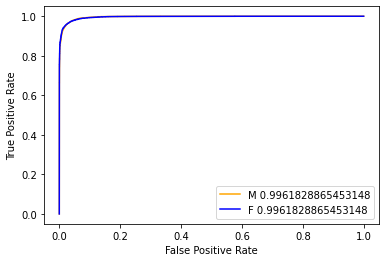

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Gender'],y_score = [prob[1] for prob in predict_df['Gender_Probability']], pos_label = 'M')
plt.plot(fpr,tpr, color='orange', label='M ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Gender'],y_score = [prob[0] for prob in predict_df['Gender_Probability']], pos_label = 'F')
plt.plot(fpr,tpr, color='blue', label='F ' + str(metrics.auc(fpr, tpr)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
test_df.insert(len(test_df.columns), 'Gender_Tensor_Id', gender_preds[2].numpy())
test_df.insert(len(test_df.columns), 'Gender_Probability', gender_preds[0].numpy().tolist())
print(test_df)
test_df.to_csv('/content/sample_data/nih_gender_nih_test.csv')

             Image Index       Finding Labels  Follow-up #  Patient ID  \
3       00000002_000.png           No Finding            0           2   
4       00000003_000.png               Hernia            0           3   
5       00000003_001.png               Hernia            1           3   
6       00000003_002.png               Hernia            2           3   
7       00000003_003.png  Hernia|Infiltration            3           3   
...                  ...                  ...          ...         ...   
112109  00030796_000.png           No Finding            0       30796   
112111  00030798_000.png           No Finding            0       30798   
112113  00030800_000.png           No Finding            0       30800   
112116  00030802_000.png           No Finding            0       30802   
112117  00030803_000.png           No Finding            0       30803   

        Patient Age Gender View Position  OriginalImage[Width  Height]  \
3                81      M           

CheXpert Gender Model Validation on NIH Test Set

In [ ]:
df = pd.read_csv('/content/nih_split.csv')
chexpert_gender_model = load_learner('/content/chexpert_gender.pkl')

In [ ]:
#Credit to the following code: https://www.kaggle.com/code/mqadii/nih-chest-x-ray-multi-classification
my_paths = glob('/s3/NIH_Clinical_Center_Chest_X-Ray_Data/Images/images*/images/*.png')
print('Number of Observations: ', len(my_paths))
img_full_paths = {os.path.basename(x): x for x in my_paths}

Number of Observations:  112120


In [ ]:
df['Path'] = df['Image Index'].map(img_full_paths.get)
df['Path'] = df['Path'].str[1:]
test_df = df[df.split=='test']

In [ ]:
chexpert_gender_model.dls.to(device='cuda')
chexpert_gender_model.model.to(device='cuda')
gender_test_dl = chexpert_gender_model.dls.test_dl(test_df)
gender_preds = chexpert_gender_model.get_preds(dl=gender_test_dl, with_decoded=True)

In [ ]:
predict_df = pd.DataFrame(test_df[['Path']])
predict_df['Gender'] = test_df[['Gender']]
predict_df['Gender_Tensor_Id'] =gender_preds[2].numpy()
predict_df['Gender_Probability'] =gender_preds[0].numpy().tolist()
chexpert_gender_model.dls.vocab

['F', 'M']

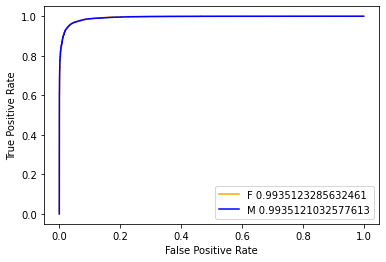

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Gender'].astype(str),y_score = [prob[0] for prob in predict_df['Gender_Probability']], pos_label = 'F')
plt.plot(fpr,tpr, color='orange', label='F ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Gender'].astype(str),y_score = [prob[1] for prob in predict_df['Gender_Probability']], pos_label = 'M')
plt.plot(fpr,tpr, color='blue', label='M ' + str(metrics.auc(fpr, tpr)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
test_df.insert(len(test_df.columns), 'Gender_Tensor_Id', gender_preds[2].numpy())
test_df.insert(len(test_df.columns), 'Gender_Probability', gender_preds[0].numpy().tolist())
print(test_df)
test_df.to_csv('/content/sample_data/chexpert_gender_nih_test.csv')

             Image Index  ...                            Gender_Probability
3       00000002_000.png  ...    [0.000828539312351495, 0.9991714954376221]
4       00000003_000.png  ...   [0.9994496703147888, 0.0005502794519998133]
5       00000003_001.png  ...  [0.9999892711639404, 1.0697754078137223e-05]
6       00000003_002.png  ...      [0.919105589389801, 0.08089440315961838]
7       00000003_003.png  ...   [0.9990839958190918, 0.0009160256595350802]
...                  ...  ...                                           ...
112109  00030796_000.png  ...    [0.012796763330698013, 0.9872031807899475]
112111  00030798_000.png  ...      [0.04410560801625252, 0.955894410610199]
112113  00030800_000.png  ...   [0.9999994039535522, 6.547699626935355e-07]
112116  00030802_000.png  ...    [0.012376218102872372, 0.9876238107681274]
112117  00030803_000.png  ...   [0.9999610185623169, 3.900532465195283e-05]

[22495 rows x 17 columns]


MIMIC Gender Model Validation on NIH Test Set

In [ ]:
df = pd.read_csv('/content/nih_split.csv')
mimic_gender_model = load_learner('/content/mimic_gender.pkl')

In [ ]:
#Credit to the following code: https://www.kaggle.com/code/mqadii/nih-chest-x-ray-multi-classification
my_paths = glob('/content/s3/NIH-ChestXray-14/NIH-CXR-14/images/*.png')
print('Number of Observations: ', len(my_paths))
img_full_paths = {os.path.basename(x): x for x in my_paths}

Number of Observations:  112120


In [ ]:
df['Path'] = df['Image Index'].map(img_full_paths.get)
df['Path'] = df['Path'].str[1:]
test_df = df[df.split=='test']

In [ ]:
mimic_gender_model.dls.to(device='cuda')
mimic_gender_model.model.to(device='cuda')
gender_test_dl = mimic_gender_model.dls.test_dl(test_df)
gender_preds = mimic_gender_model.get_preds(dl=gender_test_dl, with_decoded=True)

In [ ]:
predict_df = pd.DataFrame(test_df[['Path']])
predict_df['Gender'] = test_df[['Gender']]
predict_df['Gender_Tensor_Id'] =gender_preds[2].numpy()
predict_df['Gender_Probability'] =gender_preds[0].numpy().tolist()
mimic_gender_model.dls.vocab

['F', 'M']

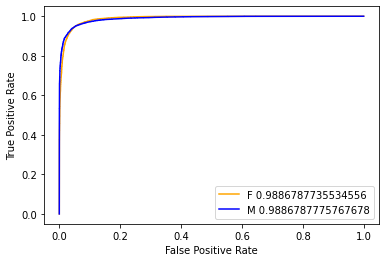

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Gender'].astype(str),y_score = [prob[0] for prob in predict_df['Gender_Probability']], pos_label = 'F')
plt.plot(fpr,tpr, color='orange', label='F ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Gender'].astype(str),y_score = [prob[1] for prob in predict_df['Gender_Probability']], pos_label = 'M')
plt.plot(fpr,tpr, color='blue', label='M ' + str(metrics.auc(fpr, tpr)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
test_df.insert(len(test_df.columns), 'Gender_Tensor_Id', gender_preds[2].numpy())
test_df.insert(len(test_df.columns), 'Gender_Probability', gender_preds[0].numpy().tolist())
print(test_df)
test_df.to_csv('/content/sample_data/mimic_gender_nih_test.csv')

             Image Index       Finding Labels  Follow-up #  Patient ID  \
3       00000002_000.png           No Finding            0           2   
4       00000003_000.png               Hernia            0           3   
5       00000003_001.png               Hernia            1           3   
6       00000003_002.png               Hernia            2           3   
7       00000003_003.png  Hernia|Infiltration            3           3   
...                  ...                  ...          ...         ...   
112109  00030796_000.png           No Finding            0       30796   
112111  00030798_000.png           No Finding            0       30798   
112113  00030800_000.png           No Finding            0       30800   
112116  00030802_000.png           No Finding            0       30802   
112117  00030803_000.png           No Finding            0       30803   

        Patient Age Gender View Position  OriginalImage[Width  Height]  \
3                81      M           